## Option Pricing

In this notebook, we estimate option prices in the Black Scholes model. For this we interpolate the implied volatility using Newton's method and regression techniques. The data consists of option prices for the S&P500 index and has been retrieved from Yahoo finance (https://finance.yahoo.com/quote/%5EGSPC?p=%5EGSPC) over several days in Januray 2020. We have one dataset for call and one for put options. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
call_prices = pd.read_csv('calls.csv', index_col=0)
put_prices = pd.read_csv('puts.csv', index_col=0)

The data contains entries for the bid and ask price of the option and their mean, as well as the strike price of the option, the days until the option expires, and the current price of the underlying S&P500 index.

In [3]:
call_prices

,Mean Price,Bid,Ask,Strike,Current Stock Price,Days to Expiry
0,2305.15,2302.4,2307.9,1000.0,3305.61,1
1,1931.15,1926.2,1936.1,1375.0,3305.61,1
2,1549.55,1547.6,1551.5,1400.0,3305.61,1
3,1715.70,1710.9,1720.5,1425.0,3305.61,1
4,1500.35,1498.4,1502.3,1450.0,3305.61,1
...,...,...,...,...,...,...
1120,292.55,287.2,297.9,3300.0,3329.62,697
1121,236.40,231.2,241.6,3400.0,3329.62,697
1122,185.95,180.9,191.0,3500.0,3329.62,697
1123,141.80,136.9,146.7,3600.0,3329.62,697


In [4]:
put_prices

,Mean Price,Bid,Ask,Strike,Current Stock Price,Days to Expiry
0,0.025,0.00,0.05,1000.0,3305.61,1
1,0.025,0.00,0.05,1100.0,3305.61,1
2,0.025,0.00,0.05,1200.0,3305.61,1
3,0.175,0.05,0.30,1250.0,3305.61,1
4,0.050,0.00,0.10,1300.0,3305.61,1
...,...,...,...,...,...,...
1340,126.150,122.10,130.20,2800.0,3329.62,697
1341,148.250,144.10,152.40,2900.0,3329.62,697
1342,173.100,168.80,177.40,3000.0,3329.62,697
1343,308.800,303.70,313.90,3400.0,3329.62,697


First we plot the mean prices of the options with respect to their strike prices. We introduce different colors for the times to expiry and different markers indicate the various stock prices at the times the data has been retrieved. 

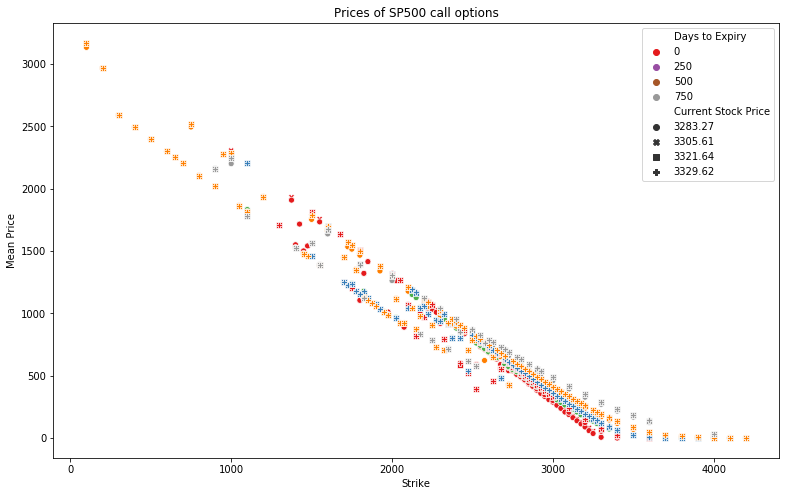

In [5]:
plt.figure(figsize=(13,8));
plt.title('Prices of SP500 call options')
sns.scatterplot(data = call_prices, x='Strike', y='Mean Price', hue='Days to Expiry', palette='Set1', style='Current Stock Price');


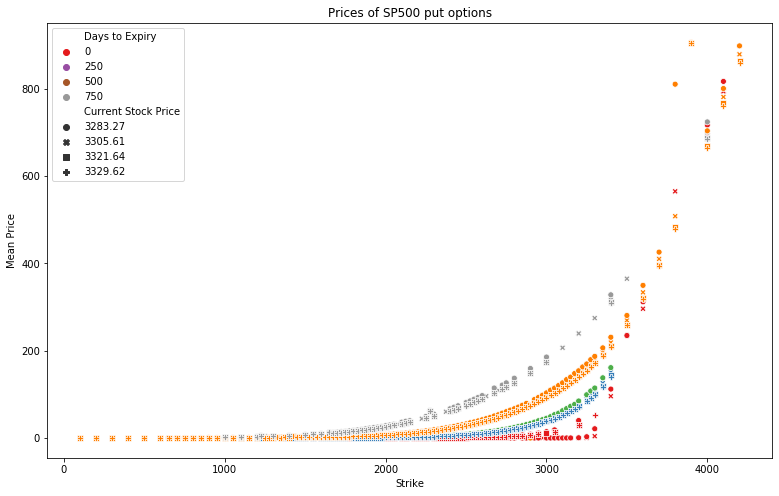

In [6]:
plt.figure(figsize=(13,8));
plt.title('Prices of SP500 put options')
sns.scatterplot(data = put_prices, x='Strike', y='Mean Price', hue='Days to Expiry', palette='Set1', style='Current Stock Price');

We want to model the option prices using the Black-Scholes formula. The only model parameter is the volatility $\sigma$. 
The derivative of the option price with respect to $\sigma$ is called the *vega* of the option. Vega is explicity given by
$$
\text{vega}(\sigma) = S\sqrt{T}\Phi\left(\frac{\log(S/K)+\frac12\sigma^2 T}{\sigma\sqrt{T}}\right)
$$
for both call and put options. We will use vega to estimate the implied volatility with Newton's method. 

In [7]:
from scipy.stats import norm

def black_scholes_price(row, sigma, call=True):
    #Models the price of a European call or put option
    #K: strike price
    #S: current stock price
    #T: time to expiry (in years)
    #sigma: volatility of the underlying asset, a model parameter
    S = row['Current Stock Price']
    T = row['Days to Expiry']/365
    K = row['Strike']
    d1 = (np.log(S / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))   
    d2 = (np.log(S / K) - 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))   
    return S*norm.cdf(d1)-K*norm.cdf(d2) if call else K*norm.cdf(-d2)-S*norm.cdf(-d1) 

def vega(row, sigma):
    #same for call and put options
    #K: strike price
    #S: current stock price
    #T: time to expiry (in years)
    #sigma: volatility of the underlying asset, a model parameter
    S = row['Current Stock Price']
    T = row['Days to Expiry']/365
    K = row['Strike']
    d1 = (np.log(S / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))       
    return S * norm.pdf(d1) * np.sqrt(T)  
    

There is no explicit formula to get $\sigma$ from the option price, but we have an explicit expression for the derivative vega. 
This allows us to use the Newton method to find the optimal $\sigma$ for each option by iterating 

$$
\sigma_{i+1} =\sigma_{i} - \frac{BS(\sigma_{i})-\Pi}{\text{vega}(\sigma_{i})},
$$
where $BS(\sigma)$ is the Black-Scholes price depending on $\sigma$ on $\Pi$ the observed option price (the entry in the *'Mean Price'* column). 

Note that when on option is far in or far out of the money (meaning that the option price is far higher or lower that the strike price), then the Black-Scholes model does not give a good approximation to the option price. What is more, vega goes to zero which renders the Newton method highly ineffective. 

Hence, we first get a set of relevant indices where we still have a chance to model the option price using Black-Scholes. The Black Scholes price is an increasing function of $\sigma$, both for call and put options. If the value $BS(0)$ is already higher than the observed price $\Pi$, there is no way we can find a positive $\sigma$ for which $BS(\sigma)$ is close to $\Pi$. Thus we do not apply the Newton method at these indices.  

We can set some parameters like the number of iterations and tolerance. It turns out that $\sigma = 0.2$ is a good initial value for this problem. 

In [8]:
calls, puts = call_prices.copy(), put_prices.copy()

num_iter =20
tol = 10**(-5)
sigma_init = 0.2

for df, is_call in [(calls, True), (puts, False)]:
    
    df['Implied Volatility'] = pd.Series(np.nan, index=range(df.shape[0]))
    df['Black Scholes Price'] = pd.Series(np.nan, index=range(df.shape[0]))
    df['Vega'] = pd.Series(np.nan, index=range(df.shape[0]))
    
    minimal_bs_price = df.apply(lambda x: black_scholes_price(x,0, call=is_call), axis=1)
    relevant_indices = df[minimal_bs_price<df['Mean Price']].index
    
    for i in relevant_indices:
        row = df.iloc[i]
        sigma = sigma_init  
        real_price = row['Mean Price']
        for _ in range(num_iter):
            bs_price = black_scholes_price(row, sigma, call=is_call)
            v = vega(row, sigma)
            diff = bs_price - real_price
            if abs(diff) < tol:
                break
            sigma -= diff / v
            
        if sigma >0:
            df['Implied Volatility'].iloc[i] = sigma
            df['Black Scholes Price'].iloc[i] = bs_price
            df['Vega'].iloc[i] = v
            
    df.dropna(axis=0, inplace=True)
    df.index = np.arange(df.shape[0])

Let's take a look at the computed volatilities.

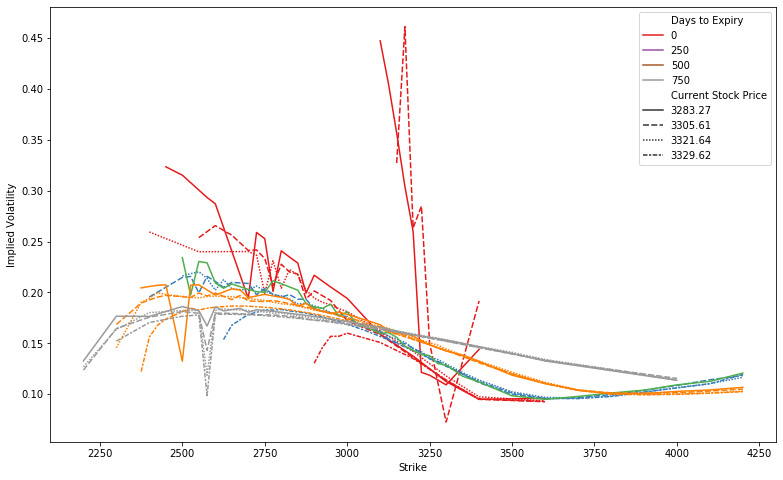

In [9]:
plt.figure(figsize=(13,8))
sns.lineplot(data=calls, x='Strike', y='Implied Volatility', hue='Days to Expiry', style='Current Stock Price', palette='Set1');

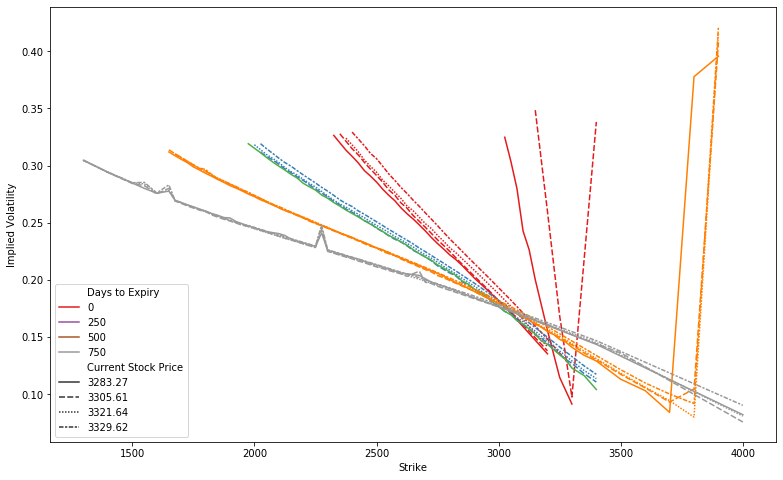

In [10]:
plt.figure(figsize=(13,8))
sns.lineplot(data=puts, x='Strike', y='Implied Volatility', hue='Days to Expiry', style='Current Stock Price', palette='Set1');

These plots look a bit noisy, but we can recognize v-shaped patterns called *volatility smiles*. The v-shape gets steeper as the time to expiry becomes smaller.

In these graphs, the volatility looks like a piecewise linear function, with different behavior when the option is in or out of the money. 

Hence we will split our data according to whether the strike price is greater or less than the current stock price and perform a linear regression on both sets independently. The result of the linear regression is stored in a new column *Predicted volatility*.

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

calls_in_the_money = calls[calls['Strike']<calls['Current Stock Price']]
calls_out_the_money = calls[calls['Strike']>calls['Current Stock Price']]
puts_in_the_money = puts[puts['Strike']>puts['Current Stock Price']]
puts_out_the_money = puts[puts['Strike']<puts['Current Stock Price']]

for df in [calls_in_the_money, calls_out_the_money, puts_in_the_money, puts_out_the_money]:
    
    X= df[['Strike', 'Current Stock Price', 'Days to Expiry']].to_numpy()
    y= df['Implied Volatility']
    
    scaler = StandardScaler()
    scaler.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X, y);
    
    sigma_pred = model.predict(X)
    
    df['Predicted Volatility'] = sigma_pred
    

Now we combine the split data again and compute the Black-Scholes prices of the options using our predicted volatilities. This should give us a good approximation of the actual price without overfitting the data.

To indicate the performance of our model, we compute the coefficient of determination (*R squared*) between the predicted Black-Scholes price and the actual price. 

In [12]:
calls = pd.concat([calls_in_the_money , calls_out_the_money ])
calls.index = range(calls.shape[0])
puts = pd.concat([puts_in_the_money , puts_out_the_money])
puts.index = range(puts.shape[0])

for (df, is_call) in [(calls, True), (puts, False)]:
    #Compute Black-Scholes prices with predicted volatilities
    bs_prices = np.zeros(df.shape[0])
    for j in range(df.shape[0]):
        sigma = df['Predicted Volatility'].iloc[j]
        row = df.iloc[j]
        bs_prices[j] = black_scholes_price(row, sigma, call=is_call)
    df['Predicted Black Scholes Price'] = bs_prices

In [13]:
from sklearn.metrics import r2_score

print("R squared on the calls dataset: {}%".format(round(100*r2_score(calls["Mean Price"], calls["Predicted Black Scholes Price"]), 2)))
print("R squared on the puts dataset: {}%".format(round(100*r2_score(puts["Mean Price"], puts["Predicted Black Scholes Price"]),2)))

R squared on the calls dataset: 99.78%
R squared on the puts dataset: 94.23%
